<a href="https://www.kaggle.com/code/hanpat99/classification-bayesianopt-and-shap-explanations?scriptVersionId=145400836" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

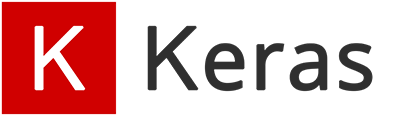

---
<a id="-1"></a>
# [Problem Statement](#0)

Build an Artificial Neural Network (ANN) to classify the types of wines (red/ white)
1. Import the necessary libraries
2. Import the csv file winequality.csv
3. Get basic information about the data set using describe() and info()
4. Using heatmap heck the correlation between the variables and remove the highly correlated variables
5. Separate the dataset into feature and the target variables and split it into training and testing dataset
6. Build a neural network model, using keras, with three hidden layers each layer having 100 neurons each. Use relu for hidden layers and sigmoid for the output layer. Use ADAM as opimizer
7. Plot the curves for error and accuracy and identify whether the model is overfitting
8. Apply the following regularization methods for further improvement of the method
    - Dropout + early stopping
    - L2 + early stopping
    - Early stopping
    - k-fold validation (use the k=5)
    
Display the results separately for each of the methods mentioned above and identify the best one

<a id="0"></a>
# [Contents:](#-1)
[Problem Statement](#-1)

[1. Imports and environment setup](#1)

[2. Preprocessing](#2)
>- [2.1 Handling Missing Values  with Decision Trees](#2.1)

[3. EDA and Feature Engineering](#3)
> - [3.1 Distributions and Normality checks with Kolmogorov-Smirnov test](#3.1)
> - [3.2 Correlation Analysis](#3.2)

[4. Model Building](#4)
> - [4.1. Baseline Model](#4.1)
> - [4.2 Model with Dropout and EarlyStopping](#4.2)
> - [4.3 Model with L2 regularization + early stopping](#4.3)
> - [4.4 Model with only Early stopping](#4.4)
> - [4.5 Model with k-fold validation (use the k=5)](#4.5)

[5. Summary](#5)

[6. Verdict](#6)

[7. A Bayesian Approach to ANN Hyperparameter Tuning](#7)
> - [7.1. Building the search space and tuning the model](#7.1)
> - [7.2. Refitting with best hyperparameters](#7.2)
> - [7.3. Error Analysis of Test Data](#7.3)

[8. Explaining the model with SHAP](#8)
> - [8.1. Single row explanations](#8.1)
> - [8.2. Multiple row explanations](#8.2)
> - [8.3 Interpreting the force plots](#8.3)

<a id="1"></a>
# [1. Imports and environment setup](#0)

In [1]:
%%capture
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from ydata_profiling import ProfileReport

# Set plot style
sns.set(color_codes=True)
sns.set_style("darkgrid")
plt.style.use("ggplot")

plt.rcParams['figure.figsize']=15,8
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/wine-quality/winequality..csv')
display(df.shape)

(6497, 13)

In [3]:
'''%%capture
profile = ProfileReport(df, title="Profiling Report")
profile.to_file(output_file = '/kaggle/working/wine_profile.html')'''

'%%capture\nprofile = ProfileReport(df, title="Profiling Report")\nprofile.to_file(output_file = \'/kaggle/working/wine_profile.html\')'

<a id="2"></a>
# [2. Preprocessing](#0)

In [4]:
print('\nInfo')
display(df.info())
display(df.describe())


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000,6489.000,6494.000,6495.000,6495.000,6497.000,6497.000,6497.000,6488.000,6493.000,6497.000,6497.000
mean,7.217,0.340,0.319,5.444,0.056,30.525,115.745,0.995,3.218,0.531,10.492,5.818
std,1.297,0.165,0.145,4.758,0.035,17.749,56.522,0.003,0.161,0.149,1.193,0.873
min,3.800,0.080,0.000,0.600,0.009,1.000,6.000,0.987,2.720,0.220,8.000,3.000
25%,6.400,0.230,0.250,1.800,0.038,17.000,77.000,0.992,3.110,0.430,9.500,5.000
50%,7.000,0.290,0.310,3.000,0.047,29.000,118.000,0.995,3.210,0.510,10.300,6.000
75%,7.700,0.400,0.390,8.100,0.065,41.000,156.000,0.997,3.320,0.600,11.300,6.000
max,15.900,1.580,1.660,65.800,0.611,289.000,440.000,1.039,4.010,2.000,14.900,9.000


In [5]:
df.columns =  df.columns.str.replace(' ', '_')

In [6]:
## Duplicates
"Duplicates found in the dataset: {:.1f}%".format(df.duplicated().sum()/df.shape[0]*100)

'Duplicates found in the dataset: 18.0%'

Nearly 18% of the data is duplicates which might create overfitting by over-representation of certain class/features. So dropping these rows.

In [7]:
df = df.drop_duplicates()

## Target Class Imbalance Check

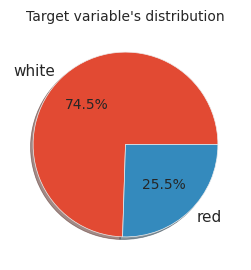

In [8]:
# Plot target variable distribution

plt.figure(figsize=(4, 3))
plt.pie(
    x = df['type'].value_counts(),
    labels=df['type'].value_counts().index,
    autopct='%1.1f%%',
    shadow=True,
    startangle=0
)
plt.title(f'Target variable\'s distribution' , fontdict={'fontsize': 10})
plt.show;

The 1:3 distribution in the target classes is not too imbalanced, so I'm not going to augment the dataset.

In [9]:
## Binarize the target
replace_dict = {'red':0, 'white':1}
df = df.replace(replace_dict)

X = df.iloc[:,1:]
y = df.type

<a id="2.1"></a>
# [2.1 Missing Values Check](#0)

In [10]:
missing = df.isna().sum().sort_values(ascending=True)
display(missing)

type                     0
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
alcohol                  0
quality                  0
residual_sugar           2
chlorides                2
citric_acid              3
sulphates                4
volatile_acidity         8
pH                       9
fixed_acidity           10
dtype: int64

**I will use DecisionTreesRegressor to impute missing values.**

**Method:**

1. First, let's take a subset of the dataset and pick columns as features for X. These are features with no missing values. 
> - For the first iteration of the loop (step 2), the features considered would be:
`type`, `free_sulfur_dioxide`, `totl_sulfur_dioxide`, `density`, `alcohol`, `quality`

2. Each of the feature with missing values would be the target. Since there are 6 features, I will fit 6 models individually. For this, I will use a custom function call, and iterate over the missing features.

3. I have used sorted the missing values because I want to impute the missing values whose count is lower first. This will become apparent in the for loop. The reason for this is because I want the splits (and predictions) to become more informative for features with higher missing values.

In [11]:
'''
Features with missing values.
I will use this when calling the custom imputation function.
'''
## List of features with missing values
y_list = missing.index.tolist()[6:]
y_list

['residual_sugar',
 'chlorides',
 'citric_acid',
 'sulphates',
 'volatile_acidity',
 'pH',
 'fixed_acidity']

In [12]:
'''
Defining the custom missing value imputer
'''

from sklearn.tree import DecisionTreeRegressor

X = df.drop('type', axis =1)
y = df.type

def missing_value_imputer(target_variable, df = X):
    
    ## Rows without missing values
    train_set = df.dropna() 
    
    ## Rows with missing values
    test_set =  df[df[target_variable].isnull()]  
    
    '''
    Select features and target. 
    The target is the variable whose missing values are to be imputed.
    '''
    features = df.columns[~df.isna().any()].tolist()
    
    X_train = train_set[features]
    y_train = train_set[target_variable]
    
    ## This subset contains missing values
    X_test = test_set[features]
    
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    ## Predict missing values
    predicted_values = model.predict(X_test)

    ## Impute missing values in the original dataset
    df.loc[df[target_variable].isnull(), target_variable] = predicted_values
    
    remaining_list = df.columns[df.isna().any()].tolist()
    
    return print(remaining_list)

'''
Now lets use the function call to impute Missing Values
'''
for feature in y_list:
    missing_value_imputer(feature)

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'pH', 'sulphates']
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'pH', 'sulphates']
['fixed_acidity', 'volatile_acidity', 'pH', 'sulphates']
['fixed_acidity', 'volatile_acidity', 'pH']
['fixed_acidity', 'pH']
['fixed_acidity']
[]


In [13]:
df = pd.concat([X,y], axis =1)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
0,7.000,0.270,0.360,20.700,0.045,45.000,170.000,1.001,3.000,0.450,8.800,6,1
1,6.300,0.300,0.340,1.600,0.049,14.000,132.000,0.994,3.300,0.490,9.500,6,1
2,8.100,0.280,0.400,6.900,0.050,30.000,97.000,0.995,3.260,0.440,10.100,6,1
3,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,1
6,6.200,0.320,0.160,7.000,0.045,30.000,136.000,0.995,3.180,0.470,9.600,6,1


## All missing values have been handled!

<a id="3"></a>
# [3. EDA and Feature Engineering](#0)

<a id="3.1"></a>
# [3.1 Distributions and Normality checks with K-S test](#0)

In [14]:
display(df.shape, df.head(3))

(5329, 13)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
0,7.000,0.270,0.360,20.700,0.045,45.000,170.000,1.001,3.000,0.450,8.800,6,1
1,6.300,0.300,0.340,1.600,0.049,14.000,132.000,0.994,3.300,0.490,9.500,6,1
2,8.100,0.280,0.400,6.900,0.050,30.000,97.000,0.995,3.260,0.440,10.100,6,1


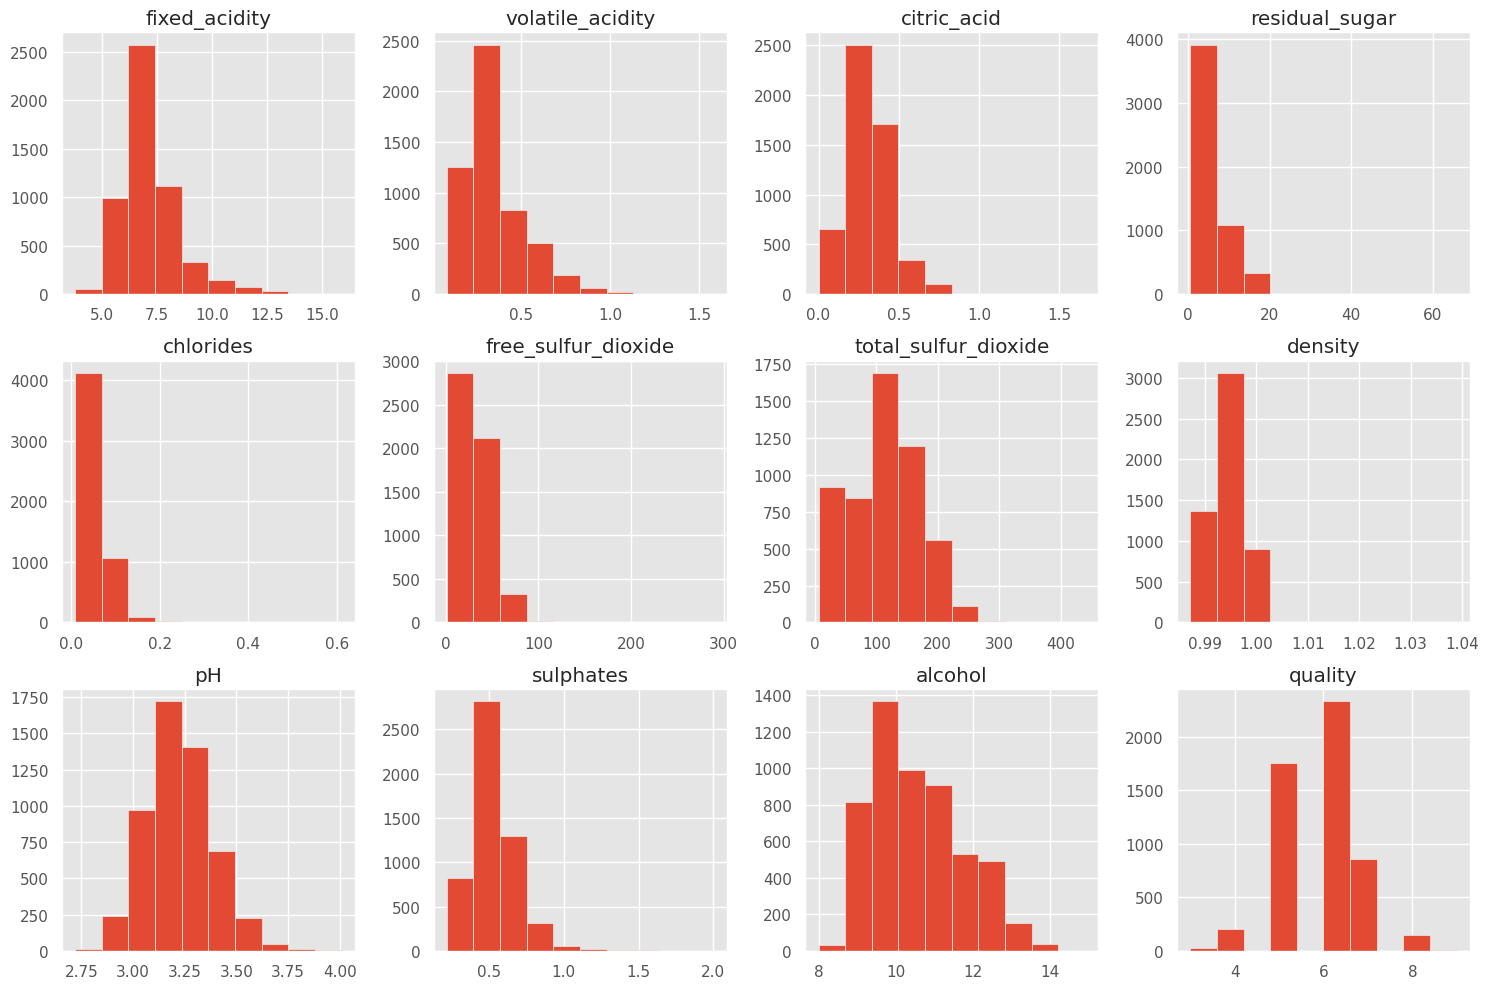

In [15]:
'''
Let's check the distributions of the features.
'''
numeric_columns = df.drop('type', axis = 1).columns.to_list()

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

axes = axes.flatten()

for i, variable in enumerate(numeric_columns):
    df[variable].hist(ax=axes[i])
    axes[i].set_title(variable) 
    
fig.tight_layout()  
plt.show();

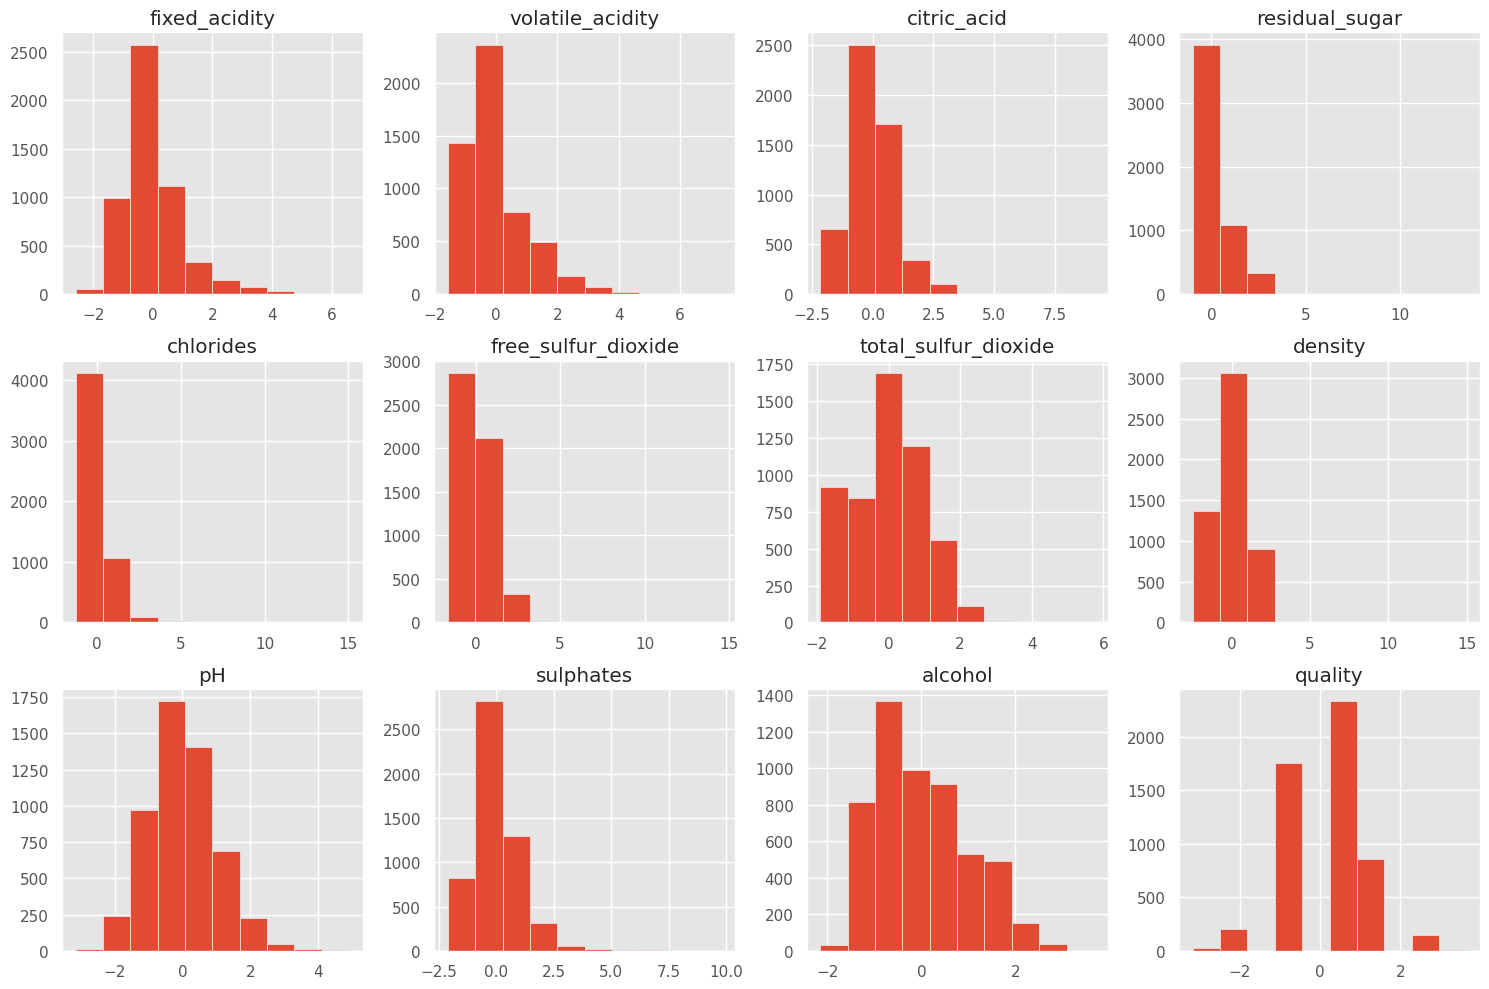

In [16]:
'''
Let's check the distributions of the features.
'''
from scipy.stats import zscore

numeric_columns = df.drop('type', axis = 1).columns.to_list()
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, variable in enumerate(numeric_columns):
    zscore(df[variable]).hist(ax=axes[i])
    axes[i].set_title(variable) 
    
fig.tight_layout()  
plt.show();

There are both Gaussian-like distributions and skewed distributions. 

- For the non-Gaussian distributions, I will selectively apply feature transformations to rescale and handle outliers.
- For eg, for `acidity` and `volatile_acidity`, it makes no sense to transform as their range is already small.
- This leaves us with `free_sulfur_dioxide` and `total_sulfur_dioxide` with a large range. I will rescale them by dividing with 100.

In [17]:
df['free_sulfur_dioxide'] = df['free_sulfur_dioxide']/100
df['total_sulfur_dioxide'] = df['total_sulfur_dioxide']/100

**Let's check if I need to normalize the data.**

For this, **Kolmogorov-Smirnov test** can be used. A p-value of 0.05 is chosen for rejecting the null-hypothesis. Skewness is also a decent indicator for checking the Normality.

**The Kolmogorov-Smirnov test**, often abbreviated as the KS test, is a statistical test used to assess whether a dataset follows a particular probability distribution, such as the normal distribution. It is a non-parametric test, which means it makes no assumptions about the underlying distribution of the data. Instead, it is used to compare the empirical cumulative distribution function (ECDF) of the sample data with the cumulative distribution function (CDF) of the hypothesized distribution.

**Hypotheses:**
- Null Hypothesis (H0): The sample data follows the specified distribution (e.g., normal distribution).
- Alternative Hypothesis (H1): The sample data does not follow the specified distribution.

**Interpretation:**
- If the p-value is less than the chosen significance level (alpha), you reject the null hypothesis, concluding that the data does not follow the specified distribution.
- If the p-value is greater than alpha, you fail to reject the null hypothesis, indicating that the data may follow the specified distribution.

**Considerations:**
- The KS test is sensitive to both location (shift) and scale (spread) differences between the sample data and the hypothesized distribution.
- It is a non-parametric test, making it useful for assessing the goodness-of-fit of data to a wide range of distributions.
- The KS test is less suitable for small sample sizes as it may lack power to detect deviations from the hypothesized distribution. The sample size should be typically above 50. For n<50, the Shapiro-Wilk test is recommended.
- It is important to choose an appropriate significance level (alpha) when interpreting the p-value. (Refer articles on p-value hacking)

In [18]:
from scipy import stats

## Select a column to check for normality (e.g., 'alcohol' column)

cols = []
kstest_statistic = []
kstest_pval = []
normal = []

for column_to_check in df.drop(['type', 'quality'], axis=1).columns:    
    values = df[column_to_check]
    ## Perform the Kolmogorov-Smirnov test for normality
    kstest_result = stats.kstest(values, 'norm')
    
    ## Check if the data follows a normal distribution 
    ## (usually, if p-value < 0.05, it's not normal)
    follows_normal_distribution = kstest_result.pvalue >= 0.05

    ###  
    cols.append(column_to_check)
    kstest_statistic.append(kstest_result.statistic)
    kstest_pval.append(kstest_result.pvalue)
    normal.append(follows_normal_distribution)
    
   
results_df = pd.DataFrame({'Column':cols, 
                          'KS Statistic':kstest_statistic, 
                          'P-value':kstest_pval, 
                          'Normal Distribution':normal})
display(results_df)

,Column,KS Statistic,P-value,Normal Distribution
0,fixed_acidity,1.000,0.000,False
1,volatile_acidity,0.543,0.000,False
2,citric_acid,0.500,0.000,False
3,residual_sugar,0.836,0.000,False
4,chlorides,0.505,0.000,False
5,free_sulfur_dioxide,0.511,0.000,False
6,total_sulfur_dioxide,0.534,0.000,False
7,density,0.838,0.000,False
8,pH,0.997,0.000,False
9,sulphates,0.610,0.000,False


In [19]:
display(df.skew())

fixed_acidity           1.651
volatile_acidity        1.505
citric_acid             0.483
residual_sugar          1.703
chlorides               5.341
free_sulfur_dioxide     1.359
total_sulfur_dioxide    0.062
density                 0.665
pH                      0.391
sulphates               1.808
alcohol                 0.546
quality                 0.149
type                   -1.124
dtype: float64

None of the continuous features are Normally Distributed. I will Normalize these features using a method known as z-score normalization.

Both sklearn and keras libraries offer solutions for z-score  normalization of datasets. Lets see how to implement these before model building.

<a id="3.2"></a>
# [3.2 Correlation Analysis](#0)

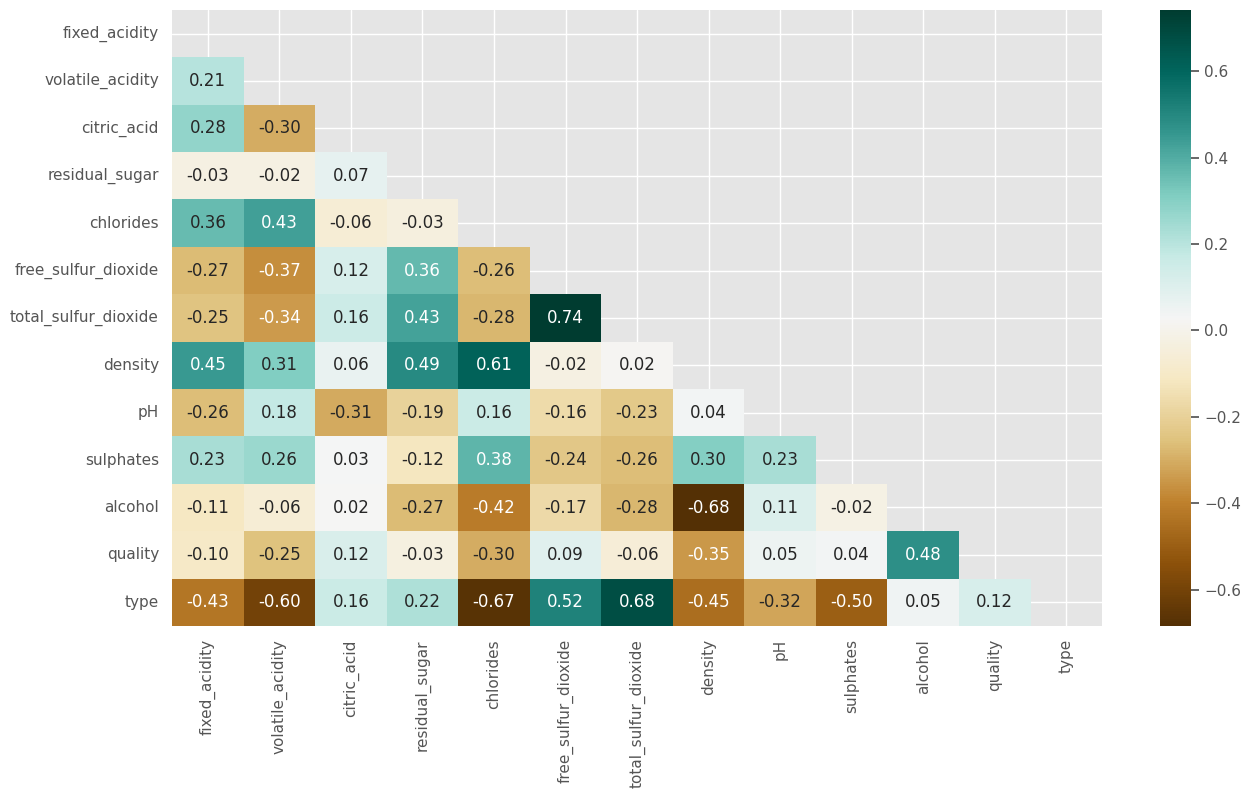

In [20]:
mask = mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(df.corr(method='spearman', numeric_only = True), 
                      fmt = '.2f',  annot = True, 
                      annot_kws = {'size': 12}, 
                      mask=mask, cmap='BrBG')

## Inferences:
- `density` is highly correlated with both `chlorides` and `alcohol`
- `total_sulfur_dioxide` and `free_sulfur_dioxide` are highly correlated.
---

I will remove `density` and `total_sulfur_dioxide`.

In [21]:
df =  df.drop(['density', 'total_sulfur_dioxide'], axis = 1)

<a id="4"></a>
# [4. Model-Building](#0)
**Model-Building tasks**
- Separate the dataset into feature and the target variables and split it into training and testing dataset
- Build a neural network model, using keras, with three hidden layers each layer having 100 neurons each. Use relu for hidden layers and sigmoid for the output layer. Use ADAM as opimizer
- Plot the curves for error and accuracy and identify whether the model is overfitting
- Apply the following regularization methods for further improvement of the method
> - Dropout + early stopping
> - L2 + early stopping
> - Early stopping
>- k-fold validation (use the k=5)

Display the results separately for each of the methods mentioned above and identify the best one

In [22]:
'''
Now that we have prepared our data, lets build a wine classification model.
'''

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
import joblib

## for explaining the model
import shap, eli5 

from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('type', axis = 1)
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = y, 
                                                    random_state = 42, stratify = y)

train_index = X_train.index
test_index = X_test.index

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

features = X.columns.tolist()
display(features)

X_train = pd.DataFrame(X_train, columns=features, index=train_index)
X_test = pd.DataFrame(X_test, columns=features, index=test_index)

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [23]:
X_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,pH,sulphates,alcohol,quality
3138,-0.233,-0.731,0.768,0.292,-0.400,0.211,-1.089,-0.160,0.210,0.224
994,1.063,-0.968,0.285,-0.723,-0.454,-0.344,0.155,0.108,-0.888,0.224
6219,-1.682,2.358,-2.198,-0.855,-0.427,-0.787,4.881,0.377,1.645,0.224
5393,2.664,0.042,1.458,-0.546,0.363,-1.398,-0.467,0.779,0.379,2.496
1958,0.148,-0.137,1.596,2.540,-0.019,1.265,-1.648,0.309,-1.563,0.224


<a id="4.1"></a>
# [4.1. Baseline Model](#0)

In [24]:
## Build the first model
def model_A(X_train = X_train):
    
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],) ) )
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
              
    return model

In [25]:
%%time
model_A = model_A()
history_A = model_A.fit(X_train, y_train, 
                        epochs=25, batch_size=64, 
                        validation_split=0.2)
joblib.dump(model_A, 'baseline_model.pkl')
joblib.dump(history_A, 'baseline_history.pkl',)

Epoch 1/25
54/54 [==============================] - 6s 8ms/step - loss: 0.2300 - accuracy: 0.9220 - val_loss: 0.0932 - val_accuracy: 0.9695
Epoch 2/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0672 - accuracy: 0.9789 - val_loss: 0.0850 - val_accuracy: 0.9766
Epoch 3/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0560 - accuracy: 0.9827 - val_loss: 0.0760 - val_accuracy: 0.9789
Epoch 4/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0472 - accuracy: 0.9859 - val_loss: 0.0683 - val_accuracy: 0.9812
Epoch 5/25
54/54 [==============================] - 0s 4ms/step - loss: 0.0417 - accuracy: 0.9865 - val_loss: 0.0634 - val_accuracy: 0.9812
Epoch 6/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0374 - accuracy: 0.9891 - val_loss: 0.0633 - val_accuracy: 0.9859
Epoch 7/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0357 - accuracy: 0.9897 - val_loss: 0.0580 - val_accuracy: 0.9859
Epoch 8/25
54/54 [==

['baseline_history.pkl']

In [26]:
def plot_performance(history, 
                     xlims_loss = False, ylims_loss = False, 
                     xlims_acc = False, ylims_acc = False, 
                     loss_incr = 0.1, acc_incr=0.1,
                     xticks_loss = list(), yticks_loss = list(), 
                     xticks_acc = list(), yticks_acc = list()
                    ):
    training_loss = history.history['loss']
    val_loss = history.history['val_loss']
    training_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1,2,1) 
    plt.plot(training_loss,'b-', label = 'Training Loss')
    plt.plot(val_loss, 'r-', label = 'Validation Loss')
    
    if xlims_loss:
        plt.xticks(np.arange(*xticks_loss, loss_incr))
    if ylims_loss:
        plt.yticks(np.arange(*yticks_loss, loss_incr))
        
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1,2,2) 
    plt.plot(training_acc,'b-', label = 'Training Accuracy')
    plt.plot(val_acc, 'r-', label = 'Validation Accuracy')
    
    if xlims_acc:
        plt.xticks(np.arange(*xticks_acc, acc_incr))
    if ylims_acc:
        plt.yticks(np.arange(*yticks_acc, acc_incr))
        
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.show();

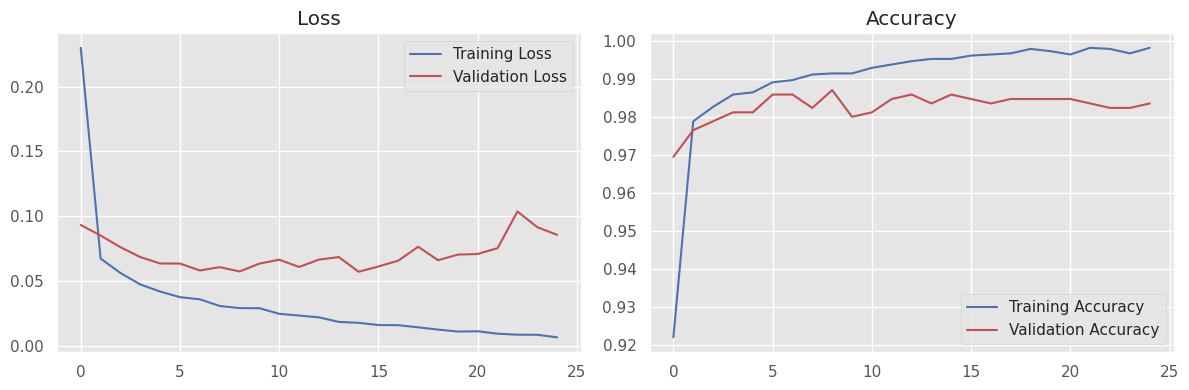

In [27]:
plot_performance(history_A)

In [28]:
from sklearn.metrics import classification_report
def cl_report(model, threshold = 0.5, X_test = X_test, y_test = y_test):
    y_preds = (model.predict(X_test)>=threshold).astype(int)
    report = classification_report(y_test, y_preds)
    
    return print(report)

In [29]:
cl_report(model_A)

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       272
           1       0.98      0.99      0.99       794

    accuracy                           0.98      1066
   macro avg       0.98      0.97      0.98      1066
weighted avg       0.98      0.98      0.98      1066



The model is indeed overfitting, as can be observed from the ever increasing validation loss. The training and validation accuracy also seems to be diverging. This is possibly due to the width of the layers not decreasing.

To correct for this, lets add Dropout layers after the 1st, 2nd and 3rd layers, along with Early Stopping.

<a id="4.2"></a>
# [4.2. Model with Dropout and EarlyStopping](#0)

In [30]:
def model_B(X_train = X_train):
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],) ) )
    model.add(Dropout(.2))          
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dropout(.4))  
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dropout(.5))  
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])                 
    
    return model

In [31]:
%%time
model_B = model_B()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, 
                               start_from_epoch = 8)

history_B = model_B.fit(X_train, y_train, 
                        epochs=25, batch_size=64, 
                        validation_split=0.2, callbacks = [early_stopping])

joblib.dump(model_B, 'dropout_earlystop_model.pkl')
joblib.dump(history_B, 'dropout_earlystop_history.pkl')

Epoch 1/25
54/54 [==============================] - 2s 9ms/step - loss: 0.3538 - accuracy: 0.8569 - val_loss: 0.1115 - val_accuracy: 0.9719
Epoch 2/25
54/54 [==============================] - 0s 6ms/step - loss: 0.0983 - accuracy: 0.9683 - val_loss: 0.0930 - val_accuracy: 0.9707
Epoch 3/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0837 - accuracy: 0.9742 - val_loss: 0.0904 - val_accuracy: 0.9754
Epoch 4/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0750 - accuracy: 0.9780 - val_loss: 0.0864 - val_accuracy: 0.9777
Epoch 5/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0679 - accuracy: 0.9789 - val_loss: 0.0772 - val_accuracy: 0.9801
Epoch 6/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0589 - accuracy: 0.9815 - val_loss: 0.0824 - val_accuracy: 0.9777
Epoch 7/25
54/54 [==============================] - 0s 5ms/step - loss: 0.0592 - accuracy: 0.9830 - val_loss: 0.0751 - val_accuracy: 0.9801
Epoch 8/25
54/54 [==

['dropout_earlystop_history.pkl']

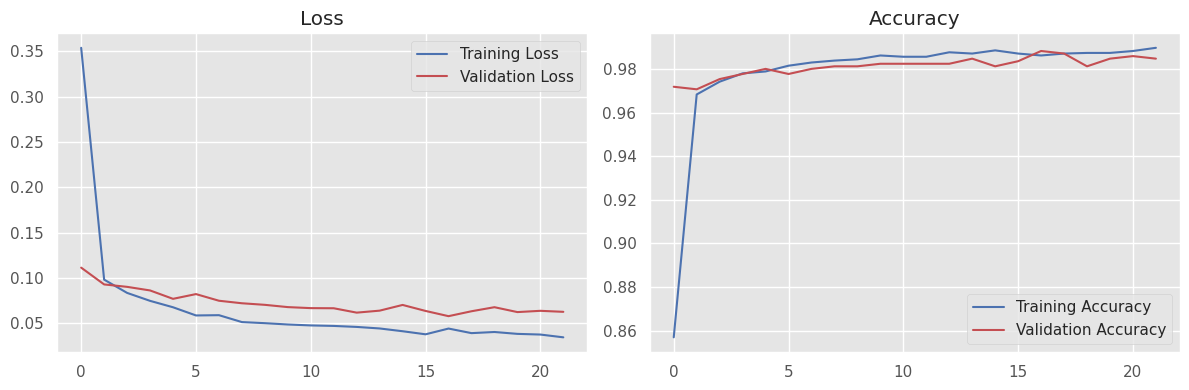

In [32]:
plot_performance(history_B)

In [33]:
cl_report(model_B)

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       272
           1       0.99      0.99      0.99       794

    accuracy                           0.98      1066
   macro avg       0.98      0.98      0.98      1066
weighted avg       0.98      0.98      0.98      1066



This model shows a significant improvement from the previous model. The training and validation loss are decreasing steadily. Both the losses more stable (without fluctuations). The training and validation accuracies are moving in step with each other and are almost converging at higher epochs. This is a positive sign.

Let's try other models and see if there is an improved performance.

<a id="4.3"></a>
# [4.3. Model with L2 regularization + early stopping](#0)

In [34]:
## Build the first model
from keras.regularizers import L2
def model_C(X_train = X_train):
    
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],), kernel_regularizer=L2(0.01) ) )
    model.add(Dense(100, activation = 'relu', kernel_regularizer=L2(0.01) ))
    model.add(Dense(100, activation = 'relu', kernel_regularizer=L2(0.01) ))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
              
    return model

In [35]:
%%time
model_C = model_C()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, 
                               start_from_epoch = 8)

history_C = model_C.fit(X_train, y_train, 
                        epochs=100, batch_size=64, 
                        validation_split=0.2, callbacks = [early_stopping])

joblib.dump(model_C, 'L2_earlystop_model.pkl')
joblib.dump(history_C, 'L2_earlystop_history.pkl')

Epoch 1/100
54/54 [==============================] - 2s 7ms/step - loss: 1.8887 - accuracy: 0.9413 - val_loss: 1.2200 - val_accuracy: 0.9683
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.8606 - accuracy: 0.9783 - val_loss: 0.6034 - val_accuracy: 0.9742
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.4435 - accuracy: 0.9792 - val_loss: 0.3433 - val_accuracy: 0.9766
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 0.2684 - accuracy: 0.9801 - val_loss: 0.2356 - val_accuracy: 0.9789
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 0.1926 - accuracy: 0.9804 - val_loss: 0.1881 - val_accuracy: 0.9801
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.1593 - accuracy: 0.9824 - val_loss: 0.1651 - val_accuracy: 0.9777
Epoch 7/100
54/54 [==============================] - 0s 5ms/step - loss: 0.1437 - accuracy: 0.9804 - val_loss: 0.1524 - val_accuracy: 0.9801
Epoch 8/100
5

['L2_earlystop_history.pkl']

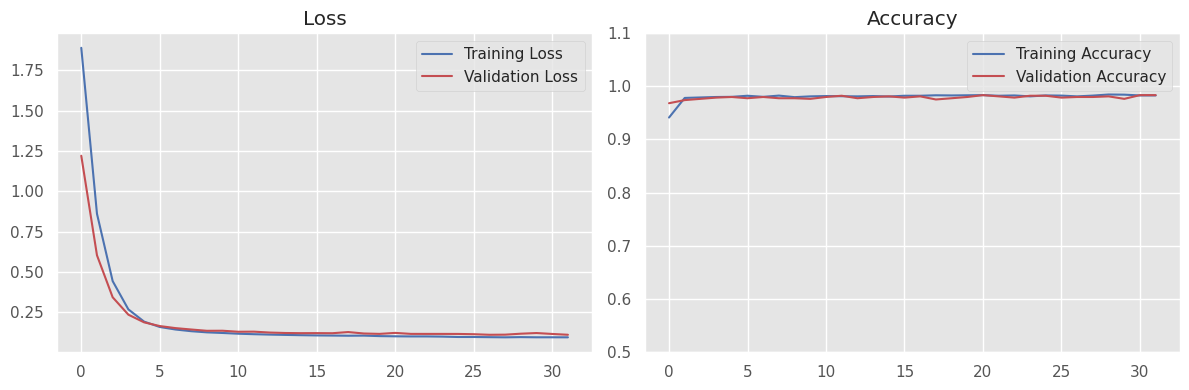

In [36]:
plot_performance(history_C,ylims_acc=True,  yticks_acc=[0.5,1.1])

In [37]:
cl_report(model_C)

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       272
           1       0.98      0.98      0.98       794

    accuracy                           0.97      1066
   macro avg       0.97      0.96      0.97      1066
weighted avg       0.97      0.97      0.97      1066



I have conflicting sentiments about the 3rd model. Looking at the loss metrics, this is perhaps the best models trained so far. 
- The losses are coinciding, and I believe theres a possibiliy for improvement by using ReduceLROnPlateau. Both the loss curves are pointing downwards, which supports this idea.
- The validation loss, however, is higher than the previous model, with the classification report being nearly identical.
- The training time per step is also identical to the previous model, although it takes significantly a higher number of epochs to converge. If training time is a consideration, I'd recommend model_B as the superior model.
- If model stability is the primary concern, then the current model with  L2 regularization + early stopping is the superior one.

<a id="4.4"></a>
# [4.4. Model with only Early stopping](#0)

In [38]:
%%time
def model_D(X_train = X_train):
    
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],) ) )
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
              
    return model

model_D = model_D()
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, 
                               start_from_epoch = 8)

history_D = model_D.fit(X_train, y_train, 
                        epochs=100, batch_size=64, 
                        validation_split=0.2, callbacks = [early_stopping])

joblib.dump(model_D, 'EarlyStop_model.pkl')
joblib.dump(history_D, 'EarlyStop_history.pkl')

Epoch 1/100
54/54 [==============================] - 2s 7ms/step - loss: 0.2226 - accuracy: 0.9276 - val_loss: 0.0871 - val_accuracy: 0.9719
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.9795 - val_loss: 0.0843 - val_accuracy: 0.9754
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0555 - accuracy: 0.9812 - val_loss: 0.0717 - val_accuracy: 0.9789
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0480 - accuracy: 0.9850 - val_loss: 0.0728 - val_accuracy: 0.9789
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0441 - accuracy: 0.9862 - val_loss: 0.0647 - val_accuracy: 0.9812
Epoch 6/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0391 - accuracy: 0.9871 - val_loss: 0.0636 - val_accuracy: 0.9812
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0367 - accuracy: 0.9889 - val_loss: 0.0720 - val_accuracy: 0.9801
Epoch 8/100
5

['EarlyStop_history.pkl']

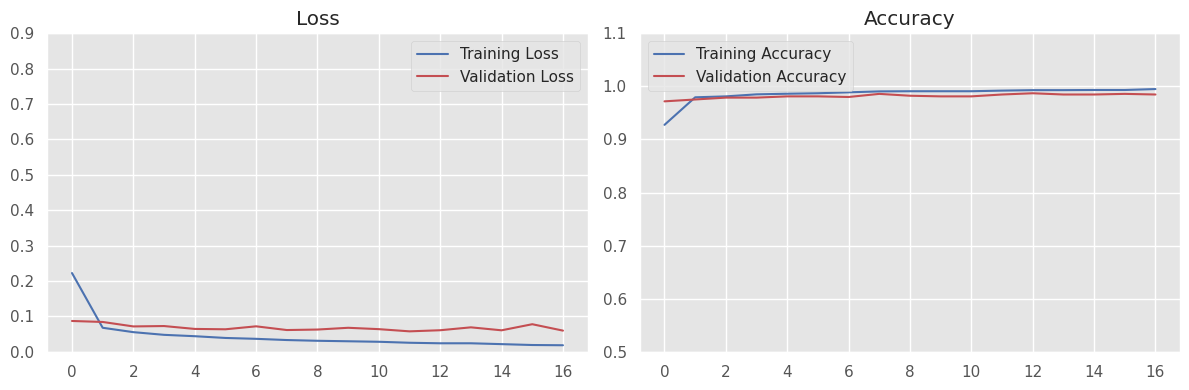

In [39]:
plot_performance(history_D,ylims_loss=True, ylims_acc= True, yticks_loss=[0, 1], yticks_acc=[0.5,1.1] )

In [40]:
cl_report(model_D)

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       272
           1       0.99      0.99      0.99       794

    accuracy                           0.98      1066
   macro avg       0.98      0.98      0.98      1066
weighted avg       0.98      0.98      0.98      1066



This is a worse performing model than the previous models, from the loss metrics alone. There is a clear overfitting, since the loss curves are diverging, and the validation loss seems to increase with each epoch.

The validation accuracy also seems to decrease while the training accuracy is increasing.

<a id="4.5"></a>
# [4.5. Model with k-fold validation (use the k=5)](#0)

In [41]:
def model_E(X_train = X_train):
    
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],) ) )
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dense(100, activation = 'relu' ))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
              
    return model

In [42]:
from sklearn.model_selection import StratifiedKFold, KFold

# Number of validation folds
k = 5 
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [43]:
## Sanity check
if (X_train.index == y_train.index).all():
    print("Indices of X_train and y_train are the same.")
else:
    print("Indices of X_train and y_train are not the same.")

Indices of X_train and y_train are the same.


In [44]:
%%time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

super_history = {}
scores = {}
full_scores = {}

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    train_index = train_index.tolist()
    val_index = val_index.tolist()
    
    X_train_fold, X_val_fold = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Create and compile the model (same as previous)
    model_kf = model_E()
    
    print('Fold number:',fold + 1)
    
    history_E = model_kf.fit(X_train_fold, y_train_fold, 
                        epochs=60, batch_size=64, 
                        validation_split=0.2, verbose = 0)
    
    threshold = 0.5
    y_preds = (model_kf.predict(X_test)>=threshold).astype(int)
    
    full_scores[fold] = precision_recall_fscore_support(y_test, y_preds)
    scores[fold] = accuracy_score(y_test, y_preds)
    super_history[fold] = (history_E, model_kf)
    
    print('\n\n')

Fold number: 1
34/34 [==============================] - 0s 1ms/step



Fold number: 2
34/34 [==============================] - 0s 1ms/step



Fold number: 3
34/34 [==============================] - 0s 1ms/step



Fold number: 4
34/34 [==============================] - 0s 2ms/step



Fold number: 5
34/34 [==============================] - 0s 1ms/step



CPU times: user 1min 7s, sys: 6.05 s, total: 1min 13s
Wall time: 1min 20s


In [45]:
average_skf_accuracy =  np.mean(list(scores.values()))
print('Avg accuracy with k-fold cv:',average_skf_accuracy)

Avg accuracy with k-fold cv: 0.9801125703564727


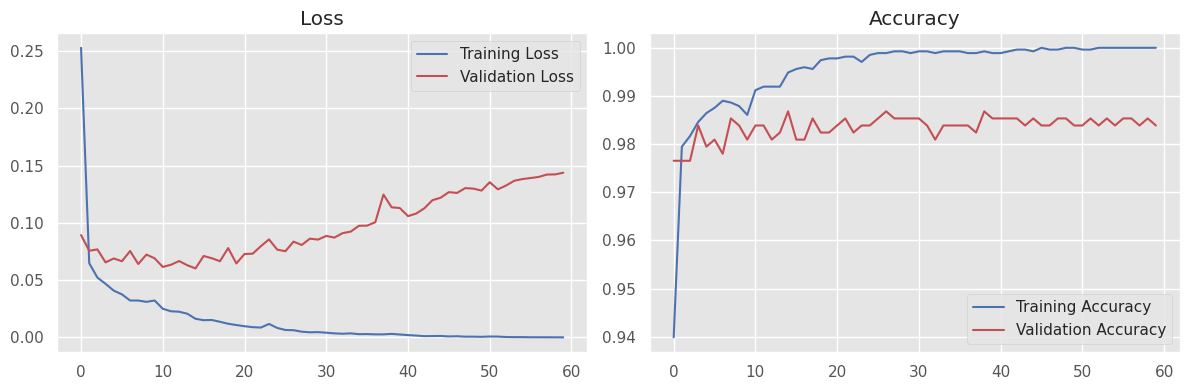

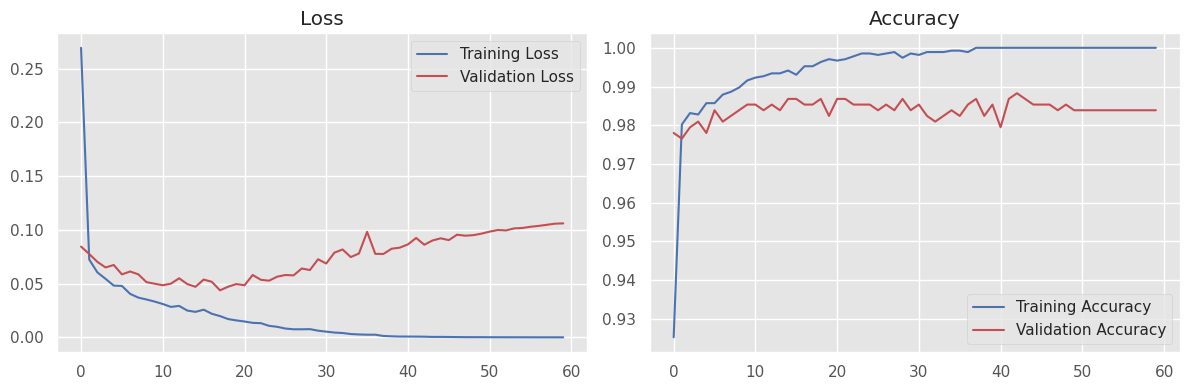

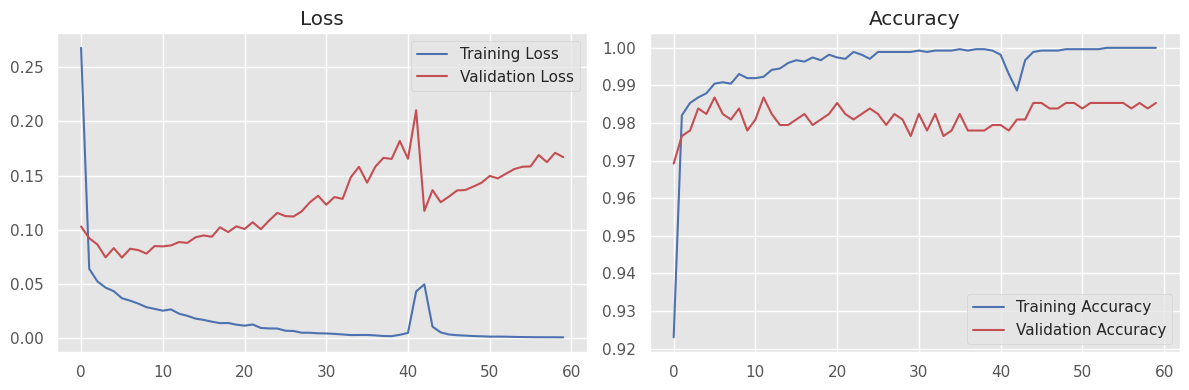

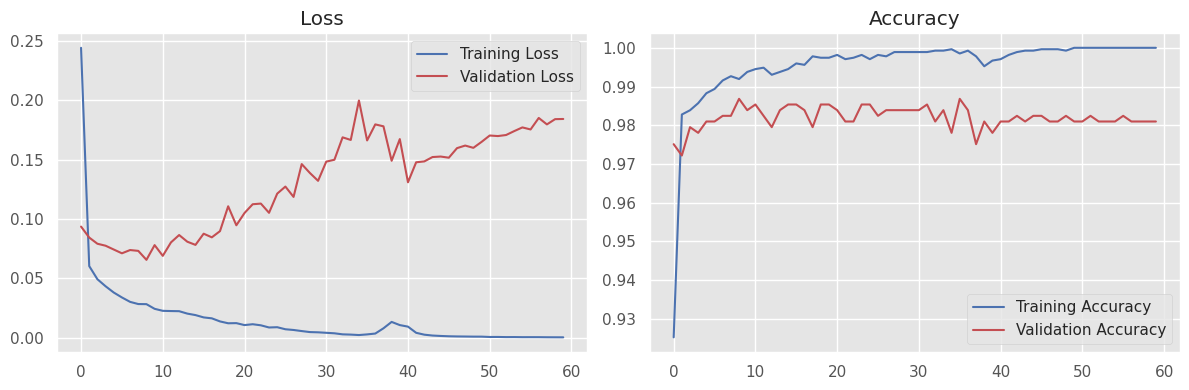

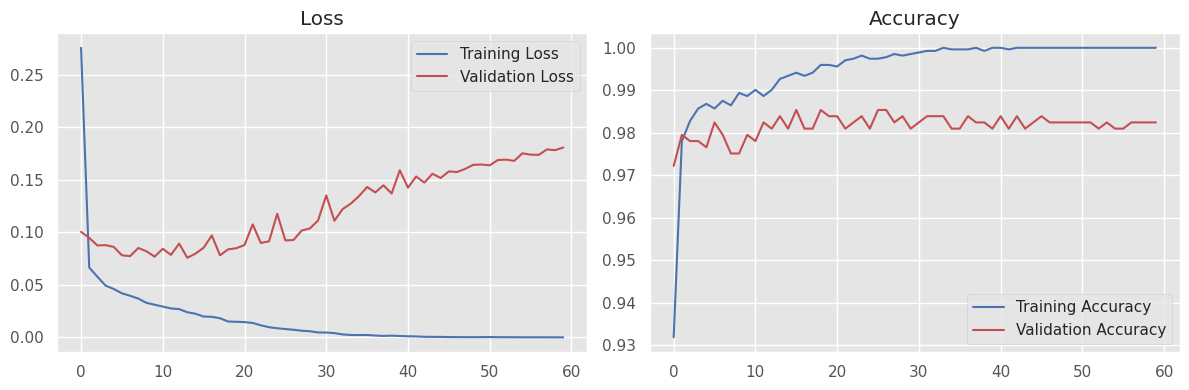

In [46]:
for _, (history, _) in super_history.items():
    plot_performance(history)

This isn't a great model, either. 

- Firstly, can be seen from the Mean Accuracy, k-Fold Cross-Validation didn't achieve the accuracy that previous models have produced.
- Secondly, the loss curves show that the model is not only overfitting, but also not stable throughout. There is little evidence to show that the model will converge since the loss curves are diverging.
- Thirdly, neither of the accuracy curves have hit 0.98, which some of the previous moels have crossed.  

The sharp fluctuations could probably be arising from the changing target class distributions in each fold, which is a characteristic of kfold. Smoother curves would probably been observed when Stratified K-fold is used.

---

<a id="5"></a>
# [5. Summary](#0)

#### **1: Baseline Model**
The model is overfitting, from observing the increasing validation loss. The training and validation accuracy curves are diverging. Provides an initial baseline, but performance is unsatisfactory.

#### **2:  Model with Dropout and EarlyStopping**
This model shows a significant improvement from the previous model. The training and validation loss are decreasing steadily. Both the losses more stable (without fluctuations). The training and validation accuracies are moving in step with each other and are almost converging at higher epochs. This is a positive sign.

#### **3. Model with L2 regularization + EarlyStopping**
Looking at the loss metrics, this is perhaps the best models trained so far. The loss-curves are stable and almost coinciding and moving downward, which indicates underfitting isnt happening.

The losses are coinciding, and I believe theres a possibiliy for improvement by using ReduceLROnPlateau. Both the loss curves are pointing downwards, which supports this idea.

The validation loss, however, is higher than the previous model, with the classification report being nearly identical.
The training time *per step* is also identical to the previous model, although it takes ~2x number of epochs to converge. If training time is a consideration, I'd recommend the previous model as the superior one.
If model stability is the primary concern, then this model is the superior one.

#### **4. Model with only EarlyStopping**
This is a worse performing model than the previous models, from the loss metrics alone. There is a clear overfitting, since the loss curves are diverging, and the validation loss seems to increase with each epoch.

The validation accuracy also seems to decrease while the training accuracy is increasing.

#### **5. Model with k-fold validation (k=5)**
This isn't a great model, either.

- Firstly, this method didn't achieve the accuracy that previous models have produced.
- Secondly, the loss curves show that the model is overfitting and unstable. There is little evidence to show that the model will converge since the loss curves are diverging.
- Thirdly, neither of the accuracy curves have hit 0.98, which some of the previous models have crossed. The sharp fluctuations could probably be arising from the changing target class distributions in each fold.

<a id="6"></a>
# [6. Verdict](#0)
The below models are suitable for classifying wine types.

**1. Model with Dropout and EarlyStopping:** To be used if computing power is to be saved.

**2. Model with L2 regularization + EarlyStopping:** To be used if model stability is desirable.


---
<a id="7"></a>
# [7. A Bayesian Approach to ANN Hyperparameter Tuning](#0)

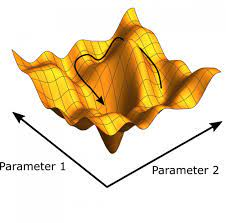

In the context of neural networks and hyperparameter tuning, Bayesian Optimization offers several advantages over traditional methods like Grid Search or Randomized Search Cross-Validation (CV). Bayesian Optimization is often superior because of the following:

1. **Efficient Exploration**: Bayesian Optimization intelligently explores hyperparameter spaces using probabilistic surrogate models. It starts with an initial set of configurations, estimating which hyperparameters might perform better. This approach efficiently explores promising regions, reducing iterations.

2. **Fewer Evaluations**: Grid Search evaluates all possible hyperparameter combinations, becoming impractical with many parameters. Randomized Search CV is better but requires a fixed number of random evaluations. Bayesian Optimization adapts based on prior results, pruning unpromising configurations for quicker convergence.

3. **Model Performance**: Bayesian Optimization focuses on optimizing specific metrics, leading to models with better overall performance, rather than randomly sampling hyperparameters.

4. **Adaptive Sampling**: It uses the surrogate model to guide evaluations towards potentially optimal configurations. Grid and Randomized Search sample independently.

5. **Sequential Nature**: Bayesian Optimization is sequential, adapting as new information comes in. It updates the surrogate model, refining performance estimates.

6. **Balancing Exploration and Exploitation**: Bayesian Optimization balances exploration (trying new configs) and exploitation (focusing on promising ones) using acquisition functions. This balance is vital, especially for complex models.

7. **Parallelization**: Bayesian Optimization's adaptability and efficient exploration make it well-suited for parallel execution, effectively distributing evaluations.

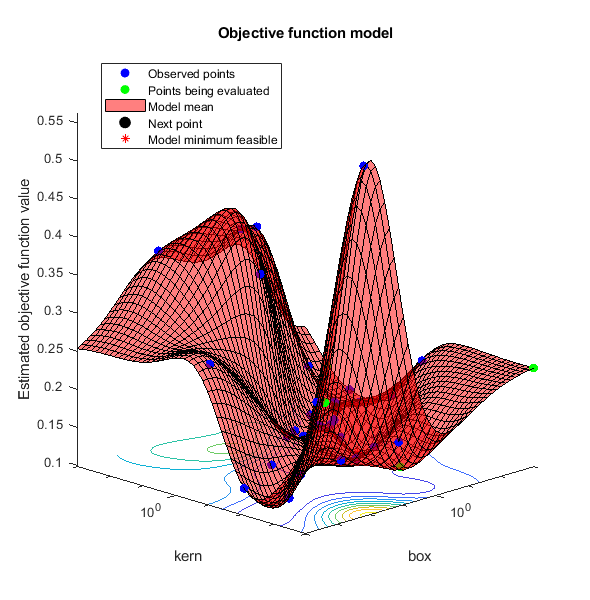


Bayesian Optimization efficiently optimizes neural network hyperparameters, requiring fewer evaluations and dynamically adapting. While Grid Search and Randomized Search CV have their uses, Bayesian Optimization excels, especially when computational resources are limited.

<a id="7.1"></a>
# [7.1. Building the search space and tuning the model](#0)

Let's use the two best-performing model configurations for tuning our model. 

First, we build the hypermodel using the kerastuner.HyperModel class, and then use Bayesian Optimization strategy to find the best hyperparameters for the model.

In [47]:
%%capture
import kerastuner as kt
from kerastuner import HyperModel, tuners
from kerastuner.tuners import BayesianOptimization

from hyperopt import STATUS_OK, fmin, hp, tpe, Trials, space_eval

Hyperopt's hp module provides a way to stochastically define the search space. Some of the commonly used options below.
>Full documentation can be found [here](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/).
- **hp.Choice(label, options):** Returns one of the options, list/tuple to be passed


In [48]:
def model_B_tuned(hp):  
    units_1 = hp.Choice('UNITS_1', np.linspace(20, 1000, 981).tolist())
    l2_1 = hp.Choice('L2_1', np.linspace(1e-4, 0.5, 10000).tolist())
    dropouts_1 = hp.Choice('DROPOUTS_1',np.linspace(0.1, 1, 100, endpoint = False).tolist())
    
    
    units_2 = hp.Choice('UNITS_2', np.linspace(20, 1000, 981).tolist())
    l2_2 = hp.Choice('L2_2', np.linspace(1e-4, 0.5, 10000).tolist())
    dropouts_2 = hp.Choice('DROPOUTS_2',np.linspace(0.1, 1, 100, endpoint = False).tolist())
    
    
    units_3 = hp.Choice('UNITS_3', np.linspace(20, 1000, 981).tolist())
    l2_3 = hp.Choice('L2_3', np.linspace(1e-4, 0.5, 10000).tolist())
    dropouts_3 = hp.Choice('DROPOUTS_3',np.linspace(0.1, 1, 100, endpoint = False).tolist())
    
    
    model = Sequential()
    model.add(Dense(units_1, activation = 'relu', input_shape = (X_train.shape[1],), kernel_regularizer = L2(l2_1)))
    model.add(Dropout(dropouts_1)) 
    
    model.add(Dense(units_2, activation = 'relu' , kernel_regularizer = L2(l2_2)))
    model.add(Dropout(dropouts_2)) 
    
    model.add(Dense(units_3, activation = 'relu' , kernel_regularizer = L2(l2_3)))
    model.add(Dropout(dropouts_3)) 
    
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1, sampling='log')
    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamax', 'rmsprop'])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'] )            
    
    return model



early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, 
                               start_from_epoch = 28)
lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 cooldown=3)


tuner = BayesianOptimization(model_B_tuned, objective='val_accuracy', max_trials=50, 
                             num_initial_points=3, directory='keras_tuner_results', project_name='model_B_tuned')
tuner.search(X_train, y_train, epochs=120,
             batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Trial 50 Complete [00h 00m 15s]
val_accuracy: 0.9788979887962341

Best val_accuracy So Far: 0.9882766604423523
Total elapsed time: 00h 28m 02s


In [49]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [50]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 206)               2266      
                                                                 
 dropout (Dropout)           (None, 206)               0         
                                                                 
 dense_1 (Dense)             (None, 979)               202653    
                                                                 
 dropout_1 (Dropout)         (None, 979)               0         
                                                                 
 dense_2 (Dense)             (None, 821)               804580    
                                                                 
 dropout_2 (Dropout)         (None, 821)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8

In [51]:
best_units_1    = best_hyperparameters.get('UNITS_1')
best_l2_1 = best_hyperparameters.get('L2_1')
best_dropouts_1 = best_hyperparameters.get('DROPOUTS_1')
    
best_units_2    = best_hyperparameters.get('UNITS_2')
best_l2_2 = best_hyperparameters.get('L2_2')
best_dropouts_2 = best_hyperparameters.get('DROPOUTS_2')
    
best_units_3    = best_hyperparameters.get('UNITS_3')
best_l2_3 = best_hyperparameters.get('L2_3')
best_dropouts_3 = best_hyperparameters.get('DROPOUTS_3')
    
best_optimizer     = best_hyperparameters.get('optimizer')
best_learning_rate = best_hyperparameters.get('learning_rate')

best_optimizer, best_learning_rate, best_l2_1, best_l2_2, best_l2_3

('adam', 0.0001, 0.0001, 0.0001, 0.0001)

<a id="7.2"></a>
# [7.2. Refitting with best hyperparameters](#0)

Lets rebuild the model using the best hyperparameters obtained.

In [52]:
def model_optimized(X_train = X_train):
    model = Sequential()
    model.add(Dense(best_units_1, activation = 'relu', input_shape = (X_train.shape[1],), kernel_regularizer = L2(best_l2_1)))
    model.add(Dropout(best_dropouts_1))          
    model.add(Dense(best_units_2, activation = 'relu' , kernel_regularizer = L2(best_l2_2)))
    model.add(Dropout(best_dropouts_2))  
    model.add(Dense(best_units_3, activation = 'relu' , kernel_regularizer = L2(best_l2_3)))
    model.add(Dropout(best_dropouts_3))  
    model.add(Dense(1, activation = 'sigmoid'))
    
      
    
    if best_optimizer == 'adam':
        optimizer_ = Adam(learning_rate=best_learning_rate)
    elif best_optimizer == 'adamax':
        optimizer_ = Adamax(learning_rate=best_learning_rate)
    else:
        optimizer_ = RMSprop(learning_rate=best_learning_rate)
        
    model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
    return model

bayesian_optimized_model = model_optimized()

In [53]:
history_model_optimized = bayesian_optimized_model.fit(X_train, y_train, 
                            epochs=120, batch_size=64, 
                            validation_split=0.2, callbacks = [early_stopping])

joblib.dump(bayesian_optimized_model, 'bayesian_optimized_model.pkl')

Epoch 1/120
54/54 [==============================] - 2s 9ms/step - loss: 0.6252 - accuracy: 0.7836 - val_loss: 0.4337 - val_accuracy: 0.9543
Epoch 2/120
54/54 [==============================] - 0s 6ms/step - loss: 0.3714 - accuracy: 0.9343 - val_loss: 0.2680 - val_accuracy: 0.9695
Epoch 3/120
54/54 [==============================] - 0s 6ms/step - loss: 0.2621 - accuracy: 0.9613 - val_loss: 0.2294 - val_accuracy: 0.9695
Epoch 4/120
54/54 [==============================] - 0s 6ms/step - loss: 0.2351 - accuracy: 0.9689 - val_loss: 0.2180 - val_accuracy: 0.9730
Epoch 5/120
54/54 [==============================] - 0s 6ms/step - loss: 0.2232 - accuracy: 0.9666 - val_loss: 0.2177 - val_accuracy: 0.9730
Epoch 6/120
54/54 [==============================] - 0s 5ms/step - loss: 0.2145 - accuracy: 0.9695 - val_loss: 0.2114 - val_accuracy: 0.9777
Epoch 7/120
54/54 [==============================] - 0s 6ms/step - loss: 0.2151 - accuracy: 0.9680 - val_loss: 0.2079 - val_accuracy: 0.9777
Epoch 8/120
5

['bayesian_optimized_model.pkl']

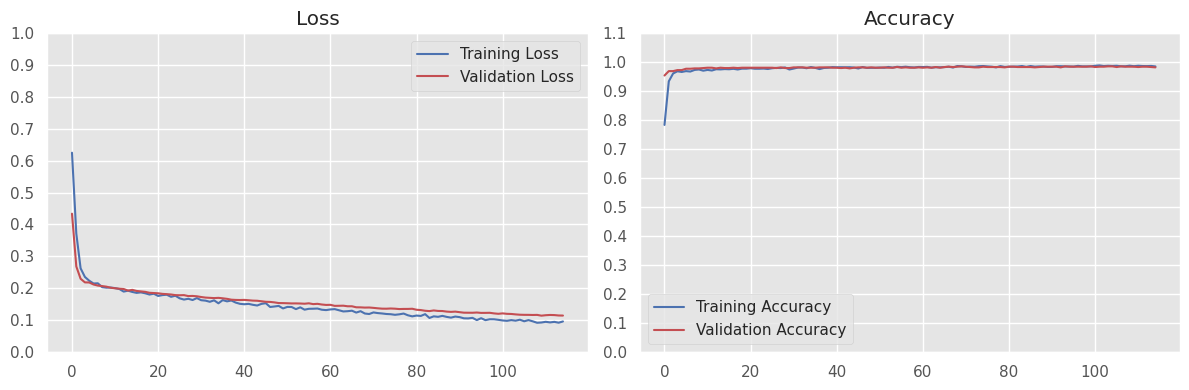

In [56]:
plot_performance(history_model_optimized, 
                 ylims_loss = True, 
                 yticks_loss = [0, 1.1], loss_incr = 0.1, 
                 ylims_acc = True, 
                 yticks_acc = [0.,1.2], acc_incr = 0.1
                )

### This is by far the best model.
1. The loss metrics are moving in step and are not diverging. This suggests a high confidence in the robustness of the model, i.e. the reliability of predictions.
2. The model, now fully optimized, learns no further information from the same data, and hence the curves are plateau out.
3. There are at least 2 different ways to improve the model performance from this point:
> 1. By changing the hypermodel to  different architecture.
> 2. By changing the parameter search space.
4. Error analysis is possible, so lets see the classification report.

<a id="7.3"></a>
# [7.3. Error Analysis in Test Data](#0)
Lets analyse the data where we had accurate predictions vs inaccurate predictions, and comparing distributions etc in the data.

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
cl_report(bayesian_optimized_model, X_test=X_test, y_test=y_test)

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       272
           1       0.99      0.98      0.99       794

    accuracy                           0.98      1066
   macro avg       0.97      0.98      0.98      1066
weighted avg       0.98      0.98      0.98      1066



In [59]:
threshold = 0.5
ypred_bayesian = (bayesian_optimized_model.predict(X_test)>=threshold).astype(int)
display(ypred_bayesian.shape)

#ypred_bayesian_S = pd.Series([preds[0] for preds in ypred_bayesian], name =  'type_pred_bayesian')

34/34 [==============================] - 0s 2ms/step


(1066, 1)

In [60]:
tn, fp, fn, tp  = confusion_matrix(y_test, ypred_bayesian, labels = [0,1]).ravel()
tn, fp, fn, tp

(265, 7, 12, 782)

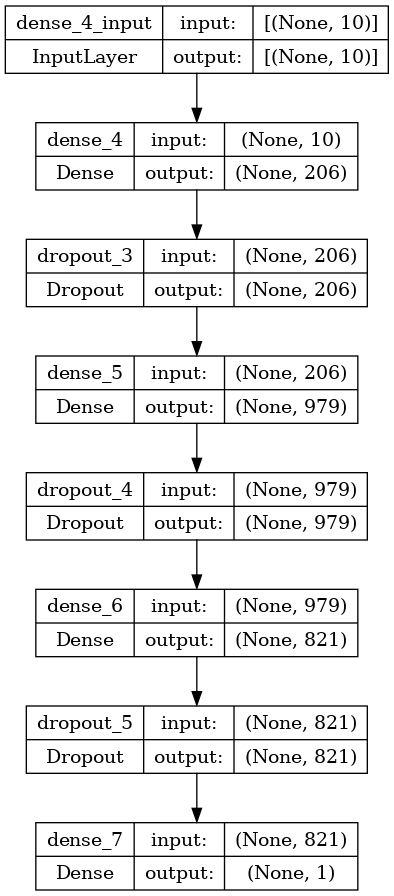

In [61]:
keras.utils.plot_model(bayesian_optimized_model, show_shapes=True) #, rankdir="LR"

### **Bayesian Optimization is a success!**
The high model validation accuracy, the impressive results from the classification report, and the coincident and converging loss curves are evidence of the successful implementation of Bayesian Optimization for Neural Networks. 

<a id="8"></a>
# [8. Explaining the model with SHAP](#0)

In [62]:
shap.initjs()
dir(shap)

['ActionOptimizer',
 'AdditiveExplainer',
 'Cohorts',
 'DeepExplainer',
 'Explainer',
 'Explanation',
 'GPUTreeExplainer',
 'GradientExplainer',
 'KernelExplainer',
 'LinearExplainer',
 'PartitionExplainer',
 'PermutationExplainer',
 'SamplingExplainer',
 'TreeExplainer',
 'UnsupportedModule',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_cext',
 '_explanation',
 '_no_matplotlib_warning',
 '_serializable',
 'actions',
 'approximate_interactions',
 'bar_plot',
 'datasets',
 'decision_plot',
 'dependence_plot',
 'embedding_plot',
 'explainers',
 'force_plot',
 'getjs',
 'group_difference_plot',
 'have_matplotlib',
 'image_plot',
 'initjs',
 'kmeans',
 'links',
 'maskers',
 'matplotlib',
 'models',
 'monitoring_plot',
 'multioutput_decision_plot',
 'other',
 'partial_dependence_plot',
 'plots',
 'sample',
 'save_html',
 'summary_plot',
 'text_plot',
 'unsupported',
 'utils',
 'waterfall_plo

<a id="8.1"></a>
# [8.1. Single row explanations](#0)

In [63]:
idx = np.random.randint(0, X_test.shape[0])
display(idx)
X_test_sample = X_test.iloc[idx]
y_test_sample = y_test.iloc[idx]

118

In [64]:
# Create an explainer for your model
explainer = shap.KernelExplainer(bayesian_optimized_model, X_train.iloc[:50])

shap_values = explainer.shap_values(X_test_sample.values.reshape(1, -1), nsamples=500)

shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[idx,:])

  0%|          | 0/1 [00:00<?, ?it/s]

The force plot above illustrates the contributions of each of the features in making the predictions. The length of the horizontal segment denotes the magnitude of contribution.

<a id="8.2"></a>
# [8.2. Multiple row explanations](#0)

In [68]:
shap_values50 = explainer.shap_values(X_train.iloc[:200,:], nsamples=500) #.iloc[50:100,:]

shap.force_plot(explainer.expected_value, shap_values50[0], X_train.iloc[:200,:])

  0%|          | 0/200 [00:00<?, ?it/s]

- The `f(x)` in the vertical-axis represents the predict_proba value of the observation.
- The other parameters in the vertical-axis dropdown list represents individual feature effects. See how the effects change across different observations by selecting `original sample ordering` in the horizontal axis dropdown menu.

<a id="8.3"></a>
# [8.3 Interpreting the force plots](#0)
In the force plots above, the colors serve specific purposes:

1. **Red/Blue Bars:** These bars signify the influence of each feature on the model's output (prediction) for a particular instance:

   - *Red bars represent positive contributions*: These features elevate the model's output compared to the expected value (the baseline).
   
   - *Blue bars represent negative contributions*: These features lower the model's output compared to the expected value.

2. **Feature Values:** The horizontal axis displays the feature values, each aligned with its respective impact bar.

3. **Baseline Reference Line:** The base value denotes the anticipated model output when no features are considered. It's depicted as a vertical dashed line on the plot.

4. **Model Prediction:** A single point on the plot represents the model's output for the explained instance. Its placement on the horizontal axis shows how the prediction compares to the baseline. If the point is right of the baseline line, the prediction exceeds the expected value; if it's left, the prediction falls below.

Force plots provide insights into how individual features influence a model's prediction for a specific case. They offer a clear view of which features have the most impact and the direction (positive or negative) of their influence on the prediction.